In [252]:
import pandas as pd
import ast
import numpy as np
from sklearn.preprocessing import MinMaxScaler

from sklearn.preprocessing import MultiLabelBinarizer, PolynomialFeatures

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

df = pd.read_csv("../Database/Dataset.csv")
df_raw = df.copy()  # Keep a backup of the original dataset

In [253]:
df.shape

(1266865, 24)

In [254]:
print(df.columns.tolist())

['id', 'title', 'vote_average', 'vote_count', 'status', 'release_date', 'revenue', 'runtime', 'adult', 'backdrop_path', 'budget', 'homepage', 'imdb_id', 'original_language', 'original_title', 'overview', 'popularity', 'poster_path', 'tagline', 'genres', 'production_companies', 'production_countries', 'spoken_languages', 'keywords']


In [255]:
# Initial Data Cleaning - Remove Columns with Too Many Null Values

# 1. Set a threshold for null values (50%).
# Columns with more null values than the threshold will be dropped.
threshold = len(df) * 0.5

# Count null values for each column.
null_counts = df.isnull().sum()


# 2. Identify columns where the null count exceeds the threshold.
cols_to_drop = null_counts[null_counts > threshold].index.tolist()

# 3. Drop the identified columns.
df = df.drop(columns=cols_to_drop)

print("Original shape:", df_raw.shape)
print("Cleaned shape:", df.shape)
print("----------------------------------------\n")

# Check which columns were dropped.
# Use set difference to find the dropped columns.
dropped_cols = set(df_raw.columns) - set(df.columns)
print("Dropped columns:", dropped_cols)
print("----------------------------------------")
print("----------------------------------------")
print("----------------------------------------")
print("Remaining columns:", df.columns.tolist())

Original shape: (1266865, 24)
Cleaned shape: (1266865, 19)
----------------------------------------

Dropped columns: {'keywords', 'homepage', 'backdrop_path', 'production_companies', 'tagline'}
----------------------------------------
----------------------------------------
----------------------------------------
Remaining columns: ['id', 'title', 'vote_average', 'vote_count', 'status', 'release_date', 'revenue', 'runtime', 'adult', 'budget', 'imdb_id', 'original_language', 'original_title', 'overview', 'popularity', 'poster_path', 'genres', 'production_countries', 'spoken_languages']


In [256]:
# Second Data Cleaning
# Drop columns that are not needed for the model.

cols_to_drop_for_model = [
    'id',
    'title',
    'original_title',
    'imdb_id',
    'poster_path',
    'overview',
    'vote_average',
    'production_countries', # already using original language and genres
    'spoken_languages' # already using original language
]

features = df.drop(columns=cols_to_drop_for_model)
target = df['vote_average']



print("Original DataFrame:", df.shape)
print("Features DataFrame:", features.shape)
print("-------------------------------------------")
print("The Features we are going to be using:", features.columns.tolist())



Original DataFrame: (1266865, 19)
Features DataFrame: (1266865, 10)
-------------------------------------------
The Features we are going to be using: ['vote_count', 'status', 'release_date', 'revenue', 'runtime', 'adult', 'budget', 'original_language', 'popularity', 'genres']


In [257]:
# check values in different columns

#print(df['status'].value_counts(dropna=False))
#print(df['adult'].value_counts(dropna=False))
#print(df['original_language'].value_counts())
df['genres'].describe()

count          733450
unique          14128
top       Documentary
freq           147145
Name: genres, dtype: object

In [258]:
# https://stackoverflow.com/questions/58033652/separating-categories-within-one-column-in-my-dataframe?utm_source=chatgpt.com

def extract_genres(genre_str):
    try:
        genres = ast.literal_eval(genre_str)
        return [g['name'] for g in genres]
    except:
        return []

df['genre_list'] = df['genres'].apply(extract_genres)



mlb = MultiLabelBinarizer()
df_genres = pd.DataFrame(
    mlb.fit_transform(df['genre_list']),
    columns=[f"has_{g}" for g in mlb.classes_],
    index=df.index
)
df = pd.concat([df, df_genres], axis=1)

In [259]:
# Feature Engineering
scaler = MinMaxScaler()

# Convert vote_count using logarithmic scaling
# prevents extreme large values
df['vote_count_log'] = np.log1p(df['vote_count'])

# Use One Hot Encoding for the STATUS
df['status_released'] = (df['status'] == 'Released').astype(int)
# By Far the majority of movies are Released -> Binary Choice
# 1 : Released, 0 : Not Released


# Convert 'release_date' to datetime and extract the YEAR
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
# coerce -> If parsing fails, set the value to NaT (Not a Time)
df['release_year'] = df['release_date'].dt.year
df['release_year'] = df['release_year'].clip(upper=2025).clip(lower=1900)

# Normalize BUDGET and REVENUE
# Fill NaN values with 0 for budget and revenue.
df['budget'] = df['budget'].fillna(0)
df['revenue'] = df['revenue'].fillna(0)

# Scale budget and revenue between 0 and 1.
df[['budget_scaled', 'revenue_scaled']] = scaler.fit_transform(df[['budget', 'revenue']])


# Convert RUNTIME to numeric, fill NaN with median.
df['runtime'] = df['runtime'].fillna(df['runtime'].median())
df[['runtime_scaled']] = scaler.fit_transform(df[['runtime']])


# Convert ADULT to binary (1 for True, 0 for False).
# This is statistically relevant, as almost 10% of movies are for adults.
df['adult'] = df['adult'].astype(bool).astype(int)


# One Hot Encoding for ORIGINAL_LANGUAGE.
df = pd.get_dummies(df, columns=['original_language'], prefix='lang', drop_first=True)


# Min Max Scaling for POPULARITY.
df[['popularity_scaled']] = scaler.fit_transform(df[['popularity']])


# Extracting features for genres with MultiLabelBinarizer in the function above.
genre_features = [col for col in df.columns if col.startswith('has_')]

# Final list of features.
feature_cols = [
    'vote_count_log',
    'status_released',
    'release_year',
    'budget_scaled',
    'revenue_scaled',
    'runtime_scaled',
    'adult',
    'popularity_scaled',
    #'spoken_languages' — handled separately
] + genre_features + [col for col in df.columns if col.startswith('lang_')]


features = df[feature_cols]
#target = df['vote_average']



# Fill the Not a Number values with 0.
features = features.fillna(0)

In [260]:
# Split Data into Training, Validation, and Test Sets
# We will use 70% for training, 20% for validation, and 10% for testing.

#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html


# Splitting the Data into train and temporary sets (70% train, 30% temp).
X_train, X_temp, y_train, y_temp = train_test_split(
    # X_train : features
    # X_temp : also features, 30 percent of the data
    # y_train : target
    # y_temp : still 30 percent of the data, but not features -> target values
    features, target,
    test_size=0.30,
    )

# Splitting the Temp set into validation and test sets (50% of temp each)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=1/3,
)




In [261]:
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)
print("Training target shape:", y_train.shape)
print("Validation target shape:", y_val.shape)
print("Test target shape:", y_test.shape)


Training set shape: (886805, 183)
Validation set shape: (253373, 183)
Test set shape: (126687, 183)
Training target shape: (886805,)
Validation target shape: (253373,)
Test target shape: (126687,)


In [262]:
# Check for object (non-numeric) dtypes
print(features.dtypes[features.dtypes == 'object'])

# Check for missing values
print("NaNs in features:", features.isna().sum().sum())
print("NaNs in target:", target.isna().sum())

Series([], dtype: object)
NaNs in features: 0
NaNs in target: 0


In [263]:
# FUNCTION FOR LINEAR REGRESSION
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
def execute_linear_regression():
# Initialize model
    model = LinearRegression()

    # Train model
    model.fit(X_train, y_train)

    # Predictions
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)

    # Return predictions and model
    return model, y_val_pred, y_test_pred

In [264]:
# FUNCTION FOR RIDGE REGRESSION

def execute_ridge_regression():


# Initialize Ridge model.
# alpha: Regularization strength (default = 1.0).
    model = Ridge()

# Train the model.
    model.fit(X_train, y_train)

# Predictions.
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)

    return y_val_pred, y_test_pred

In [265]:
# FUNCTION FOR POLYNOMIAL REGRESSION
def execute_polynomial_regression():

# Initialize model.
    model = LinearRegression()

# Select numeric features for polynomial transform; not too many to avoid heavy workload.
    numeric_features = ['vote_count_log', 'budget_scaled', 'revenue_scaled', 'runtime_scaled', 'popularity_scaled']

# Create subsets for training, validation, and testing.
    x_train_num = X_train[numeric_features]
    x_val_num = X_val[numeric_features]
    x_test_num = X_test[numeric_features]


# Create Polynomial Features of degree 2.
    poly = PolynomialFeatures(degree=2, include_bias=False)

# Here, we create polynomial features for the numeric columns.
# .to_numpy() is not needed here as fit_transform handles it.
    x_train_poly = poly.fit_transform(x_train_num)
    x_val_poly = poly.transform(x_val_num)
    x_test_poly = poly.transform(x_test_num)

# Use set difference to obtain features that are not numeric.
    x_train_other = X_train.drop(columns=numeric_features)
    x_val_other = X_val.drop(columns=numeric_features)
    x_test_other = X_test.drop(columns=numeric_features)

# Combine polynomial numeric features with the rest.
# hstack combines the arrays horizontally.
# here, .to_numpy() is needed to convert DataFrames to NumPy arrays.
    x_train_final = np.hstack([x_train_poly, x_train_other.to_numpy()])
    x_val_final = np.hstack([x_val_poly, x_val_other.to_numpy()])
    x_test_final = np.hstack([x_test_poly, x_test_other.to_numpy()])

# Train the model.

    model.fit(x_train_final, y_train)

# Predict target features for validation and test sets.
    y_val_pred = model.predict(x_val_final)
    y_test_pred = model.predict(x_test_final)

# Return predictions.
    return y_val_pred, y_test_pred

In [266]:
def execute_random_forest_regression():
    # Initialize the Random Forest Regressor model.
    model = RandomForestRegressor(
        n_estimators=100,
        min_samples_leaf=10,
        random_state=42,
        n_jobs=-1
    )

    # Train the model on the training data.
    model.fit(X_train, y_train)

    # Make predictions on all data splits.
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)

    return y_train_pred, y_val_pred, y_test_pred

In [267]:
# Run the chosen model
# Available models are:
# 1. Linear Regression
# 2. Ridge Regression
# 3. Polynomial Regression (Linear Regression using Polynomial Features)
y_train_pred, y_val_pred, y_test_pred = execute_random_forest_regression()

# Clip predictions to the valid range [0, 10]
y_train_pred = np.clip(y_train_pred, 0, 10)
y_val_pred = np.clip(y_val_pred, 0, 10)
y_test_pred = np.clip(y_test_pred, 0, 10)


# Now we can look at how well the chosen model performs.

# R² score
r2_train = r2_score(y_train, y_train_pred)
r2_val = r2_score(y_val, y_val_pred)
r2_test = r2_score(y_test, y_test_pred)

# Mean Squared Error
mse_train = mean_squared_error(y_train, y_train_pred)
mse_val = mean_squared_error(y_val, y_val_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print("📊 Training R2:", r2_train)
print("----------------------")
print("📊 Validation R2:", r2_val)
print("----------------------")
print("📊 Test R2:", r2_test)
print("----------------------")
print("📉 Training MSE:", mse_train)
print("----------------------")
print("📉 Validation MSE:", mse_val)
print("----------------------")
print("📉 Test MSE:", mse_test)
print("----------------------")


📊 Training R2: 0.9136448709446647
----------------------
📊 Validation R2: 0.8923373160085195
----------------------
📊 Test R2: 0.8912584751905359
----------------------
📉 Training MSE: 0.7492199434312895
----------------------
📉 Validation MSE: 0.929993242603553
----------------------
📉 Test MSE: 0.9376538911471565
----------------------


In [268]:


# Create a DataFrame with predictions, actuals, and titles.
results = pd.DataFrame({

    # take the correct movie title
    'title': df.loc[X_test.index, 'title'],

    'predicted_rating': y_test_pred,

    'actual_rating': y_test
})

# Round values for easier reading.
results['predicted_rating'] = results['predicted_rating'].round(2)
results['actual_rating'] = results['actual_rating'].round(2)

res_non_zero = results[results['actual_rating'] > 0]

# Show a random sample of 20 movies.
sample_results = res_non_zero.sample(20, random_state=42)

display(sample_results)

,title,predicted_rating,actual_rating
148872,Seven Into Hell,4.78,4.30
116732,Tolle Nacht,5.58,5.00
296620,Like the Sun,6.48,10.00
37644,Baby's First Steps,5.51,5.60
193037,L'uragano,4.32,5.50
350956,Come Together,6.26,5.50
201348,No Man Is an Island,5.99,8.20
113384,Thondan,5.32,6.00
108956,Critical Mass,4.82,3.80
186624,Prince Albert: A Victorian Hero Revealed,6.92,7.50


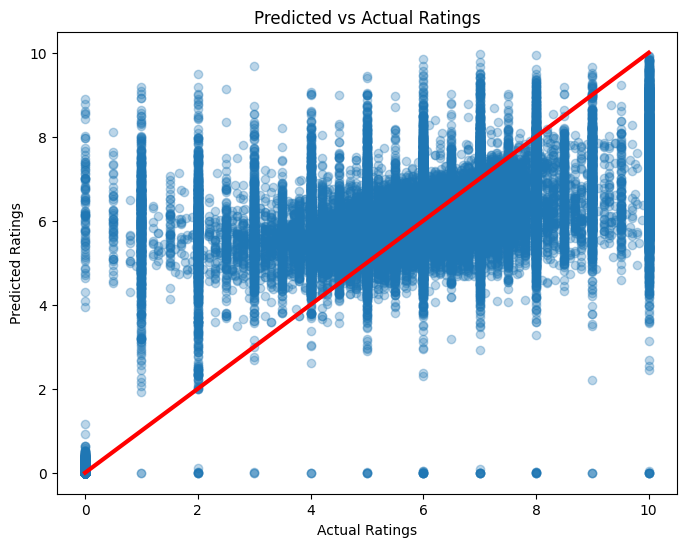

In [269]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.3)
plt.xlabel("Actual Ratings")
plt.ylabel("Predicted Ratings")
plt.title("Predicted vs Actual Ratings")
plt.plot([0, 10], [0, 10], 'r', lw=3)  # Perfect prediction line
plt.show()